In [2]:
from io import open
import glob
import os
import unicodedata
import string
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import HTML
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, LSTM
from keras.regularizers import l2

/home/gregory/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Data

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/English.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Polish.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Arabic.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt']


In [4]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(categories=None):
    names_list = []
    for filename in findFiles('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df
    

languages = ["English","French","Italian","German","Spanish"]
names = load_data(languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [5]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)
names.groupby('lang')['name'].count()

Maximum name length:  18


lang
English    3668
French      277
German      724
Italian     709
Spanish     298
Name: name, dtype: int64

### Alphabet

Extract from the list of names all the characters occurring. This gives the basis for constructing a vector space representation of the characters by one-hot-vectors.

Foresee a suitable character for the end of the word, e.g. 'END'.

In [6]:
### START YOUR CODE
alphabet = []
letters = {}
for name in names.name:
    for c in name:
        if c not in letters:
            letters[c] = 1
            alphabet.append(c)

alphabet.append("END")
### END YOUR CODE
alphabet.append('-') # added for later purpose
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  75
['A', 'b', 'a', 's', 'e', 'y', 'o', 't', 'd', 'i', 'l', 'r', 'h', 'm', 'c', 'k', 'n', 'g', 'w', 'u', 'x', 'f', 'p', 'v', 'z', 'B', 'j', 'C', 'D', ' ', 'E', 'F', 'G', 'H', 'I', 'J', 'q', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'à', 'ó', 'ò', 'é', "'", 'ù', 'ì', 'è', 'ü', 'ä', 'ö', 'ß', 'X', 'É', 'ê', 'ç', 'Á', 'ú', 'í', 'á', 'ñ', 'END', '-']


### Vector Representations

In [7]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen, char_index):
    '''
    Create a vector representation for the given name. A list of length maxlen, each element being a 
    numpy array of lenght len_vocab. 
    
    Parameters:
    maxlen: lenght of the list
    char_index: dict that returns the index for a given character
    '''
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j],size) for j in str(name)]
    # fill the rest with END
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'],size))
    ### START YOUR CODE
    return vector

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen,char_index)]))[0]
    return lang_from_output(score)

In [8]:
print(lang_representation("French",language_to_index))

[0. 0. 0. 1. 0.]


In [9]:
msk = np.random.rand(len(names)) < 0.8
train = names[msk]
test = names[~msk]

In [10]:
X_train = []
Y_train = []
for name in train.name:
    X_train.append(name_representation(name,maxlen,char_index))
for lang in train.lang:
    Y_train.append(lang_representation(lang, language_to_index))

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
print(X_train.shape,Y_train.shape) 

(4532, 18, 75) (4532, 5)


In [11]:
X_test = []
Y_test = []
for name in test.name:
    X_test.append(name_representation(name,maxlen,char_index))
for lang in test.lang:
    Y_test.append(lang_representation(lang, language_to_index))
        
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_test.shape,Y_test.shape) 

(1144, 18, 75) (1144, 5)


### Define and Train the Model

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [12]:
### START YOUR CODE
n_languages = len(languages)
n_hidden = 64

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=True, input_shape=(maxlen,len_alphabet)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=n_hidden, return_sequences=False, input_shape=(maxlen,len_alphabet)))
model.add(Dropout(0.2))
model.add(Dense(n_languages, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### END YOUR CODE
model.summary()

18 75
(4532, 18, 75)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 18, 64)            8960      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


In [13]:
### START YOUR CODE
B=200
E=100
log = model.fit(X_train,Y_train,batch_size=B,epochs=E,verbose=1,validation_data=(X_test,Y_test))
### END YOUR CODE

Train on 4532 samples, validate on 1144 samples
Epoch 1/100
4532/4532 [==============================] - 2s 402us/step - loss: 1.1878 - acc: 0.6083 - val_loss: 1.0743 - val_acc: 0.6407
Epoch 2/100
4532/4532 [==============================] - 1s 227us/step - loss: 1.0129 - acc: 0.6613 - val_loss: 0.9141 - val_acc: 0.6740
Epoch 3/100
4532/4532 [==============================] - 1s 229us/step - loss: 0.8785 - acc: 0.7015 - val_loss: 0.8186 - val_acc: 0.7010
Epoch 4/100
4532/4532 [==============================] - 2s 364us/step - loss: 0.8121 - acc: 0.7160 - val_loss: 0.7722 - val_acc: 0.7124
Epoch 5/100
4532/4532 [==============================] - 1s 239us/step - loss: 0.7417 - acc: 0.7407 - val_loss: 0.7415 - val_acc: 0.7212
Epoch 6/100
4532/4532 [==============================] - 1s 231us/step - loss: 0.6992 - acc: 0.7555 - val_loss: 0.7112 - val_acc: 0.7264
Epoch 7/100
4532/4532 [==============================] - 1s 234us/step - loss: 0.6825 - acc: 0.7553 - val_loss: 0.7296 - val_acc: 

KeyboardInterrupt: 

In [93]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

1071/1071 [==============================] - 0s 255us/step
Test score: 0.8181301930121013
Test accuracy: 0.7852474323340825


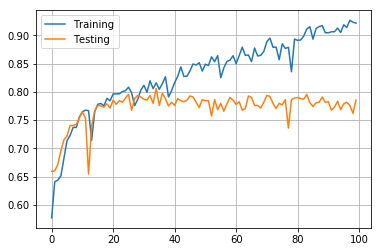

In [94]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

### Some additional outputs: Classify the last names of all the students and teaching personal in the class.

In [95]:
df_samples = pd.read_csv("stud_names.csv")
df_samples.columns=["First","Last"]
#pred_langs = [predict(unicodeToAscii(name), model) for name in df_samples.Last]
pred_langs = [predict(name, model) for name in df_samples.Last]
df_samples["pred0"] = pred_langs
df_samples

,First,Last,pred0
0,Alexander,Andreev,English
1,Anastasia,Taranova,Italian
2,Andreas,Caduff,English
3,Andreas,Bachmann,German
4,Andreas,Waldis,English
5,Armin,Grossrieder,German
6,Benjamin,Kühnis,German
7,Björn,Hasselmann,German
8,Cédric,Huwyler,English
9,Christian,von Gunten,German


### Confusion matrix

Compute the confusion matrix and jduge for which languages the names are hard to classify. 

In [102]:
### START YOUR CODE
from sklearn import metrics

predictions = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))
### END YOUR CODE
print(cm)

[[655  11  19  13   8]
 [ 18  91   2   4  12]
 [ 55   2  56   4   0]
 [ 36   6   3  14   6]
 [ 15  12   1   3  25]]


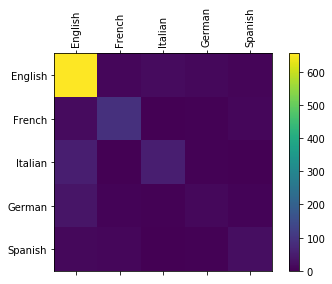

In [103]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()